# House Sales in King County, USA

A dataset from [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) containing prices of houses is provided.

We want to build a  model that can determine the prices of a given house according to a number of features. We will use a subset of the data for training and the remaining for testing our modeling.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Modeling: Once we have the data, we create some features and then the modeling stage begins, making use of different models with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set, then we review those results against their actual values to determine the performance of the model, and finally, outline our conclusions.

In [23]:
library(e1071)
library(caret)
library(ranger)
library(GGally)
library(ggplot2)
library(xgboost)
library(lubridate)
library(data.table)

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [24]:
set.seed(9560)

### Data Loading

Here we load the necessary data, print its first rows and describe its contents.

In [25]:
train<-fread('https://gist.githubusercontent.com/akoury/da3cdb6bfde9eb2f3f5d3f5246dfd6b6/raw/1b057c119af85ab22330a50239d5c0bdbab7fb64/train.csv')
test<-fread('https://gist.githubusercontent.com/akoury/83c7ce5544dc467a696967bd13d4f498/raw/e9a54dce92f6d115d1e08cbf7668f5cf70e60598/test.csv')

str(train)

Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”

Classes ‘data.table’ and 'data.frame':	17277 obs. of  21 variables:
 $ id           : 'integer64' num  4.54e-314 2.29e-315 1.10e-314 3.05e-314 3.16e-314 ...
 $ date         : chr  "5/13/2014" "8/27/2014" "7/18/2014" "1/30/2015" ...
 $ price        : num  225000 641250 810000 330000 530000 ...
 $ bedrooms     : int  3 3 4 4 4 4 4 3 4 3 ...
 $ bathrooms    : num  1.5 2.5 3.5 1.5 1.75 3.5 3.25 2.25 2.5 1.5 ...
 $ sqft_living  : int  1250 2220 3980 1890 1814 3120 4160 1440 2250 2540 ...
 $ sqft_lot     : int  7500 2550 209523 7540 5000 5086 47480 10500 6840 9520 ...
 $ floors       : num  1 3 2 1 1 2 2 1 2 1 ...
 $ waterfront   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : int  0 2 2 0 0 0 0 0 0 0 ...
 $ condition    : int  3 3 3 4 4 3 3 3 3 3 ...
 $ grade        : int  7 10 9 7 7 9 10 8 9 8 ...
 $ sqft_above   : int  1250 2220 3980 1890 944 2480 4160 1130 2250 1500 ...
 $ sqft_basement: int  0 0 0 0 870 640 0 310 0 1040 ...
 $ yr_built     : int  1967 1990 2006 1967 1951 2008 1995 1983

In [4]:
summary(train)

       id        date               price            bedrooms     
 Min.   :0   Length:17277       Min.   :  78000   Min.   : 1.000  
 1st Qu.:0   Class :character   1st Qu.: 320000   1st Qu.: 3.000  
 Median :0   Mode  :character   Median : 450000   Median : 3.000  
 Mean   :0                      Mean   : 539865   Mean   : 3.369  
 3rd Qu.:0                      3rd Qu.: 645500   3rd Qu.: 4.000  
 Max.   :0                      Max.   :7700000   Max.   :33.000  
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.500   Min.   :  370   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1430   1st Qu.:   5050   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7620   Median :1.500  
 Mean   :2.114   Mean   : 2080   Mean   :  15186   Mean   :1.493  
 3rd Qu.:2.500   3rd Qu.: 2550   3rd Qu.:  10695   3rd Qu.:2.000  
 Max.   :8.000   Max.   :13540   Max.   :1164794   Max.   :3.500  
   waterfront            view          condition         grade

In [5]:
head(train)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,⋯,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4.537352e-314,5/13/2014,225000,3,1.50,1250,7500,1,0,0,⋯,7,1250,0,1967,0,98030,47.3719,-122.215,1260,7563
2.292468e-315,8/27/2014,641250,3,2.50,2220,2550,3,0,2,⋯,10,2220,0,1990,0,98117,47.6963,-122.393,2200,5610
1.098841e-314,7/18/2014,810000,4,3.50,3980,209523,2,0,2,⋯,9,3980,0,2006,0,98024,47.5574,-121.890,2220,65775
3.045372e-314,1/30/2015,330000,4,1.50,1890,7540,1,0,0,⋯,7,1890,0,1967,0,98155,47.7534,-122.318,1890,8515
3.158069e-314,5/23/2014,530000,4,1.75,1814,5000,1,0,0,⋯,7,944,870,1951,0,98115,47.6840,-122.281,1290,5000
3.939779e-314,5/20/2014,953007,4,3.50,3120,5086,2,0,0,⋯,9,2480,640,2008,0,98115,47.6762,-122.288,1880,5092


### Missing Data

We check if there is any missing data.

In [6]:
sapply(train, function(x) sum(is.na(x)))

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15 
            0

### Converting column types
Now we convert the data types of multiple columns.

#### Numericals

In [26]:
train[ , which(sapply(train, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(train, is.integer)]
test[ , which(sapply(test, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(test, is.integer)]

#### Dates
We extract the year, month and days since posting

In [27]:
train$date<-mdy(train$date)
train$year<-year(train$date)
train$month<-month(train$date)
train$days_since<-as.numeric(Sys.Date() - train$date)

test$date<-mdy(test$date)
test$year<-year(test$date)
test$month<-month(test$date)
test$days_since<-as.numeric(Sys.Date() - test$date)

#### Categories

In [75]:
# # lets now turn characters into factors
# # still some integer variables...
# data_proc[ , names(data_proc)[sapply(data_proc, is.character)]:=lapply(.SD,as.factor),
#            .SDcols = names(data_proc)[sapply(data_proc, is.character)]]

# # lets re-order the factor levels of make in decreasing order
# data_proc[, make:=factor(make, levels=names(sort(summary(data_proc$make), dec=T)))]
# levels(data_proc$make)

# # We will create a label that will agregate into "others" those makers with less than 3% of share
# niche_cars<-names(which(summary(data_proc$make)/nrow(data_proc)<0.03))
# niche_cars
# data_proc[, make_agg:=as.factor(ifelse(make%in%niche_cars,'others',as.character(make)))]
# # we drop off the former make variable
# data_proc[, make:=NULL]


# # Now lets check the number of categories per factor variable

# factor_variables<-names(data_proc)[sapply(data_proc, is.factor)]
# count_factor_variables<-sapply(data_proc[,factor_variables, with=F], summary)
# count_factor_variables

# # lets define a rule... if a label weight less than 10% goes into the "others" bag:
# f_other<-function(var){
  
#   count_levels<-summary(var)/length(var)
#   to_bag<-names(which(count_levels<0.1))
  
#   reduced_var<-as.factor(ifelse(as.character(var)%in%to_bag,'others',as.character(var)))
  
#   return(reduced_var)
# }

# # and we apply the function to our factor variables
# data_proc[, (factor_variables):=lapply(.SD, f_other), .SDcols=factor_variables]

# sapply(data_proc[,factor_variables, with=F], summary)

### Dropping initial columnss
Now we drop unneeded columns.

In [28]:
train[, c('id','date'):=NULL]
test[, c('id','date'):=NULL]

head(train)

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,⋯,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,days_since
225000,3,1.50,1250,7500,1,0,0,3,7,⋯,1967,0,98030,47.3719,-122.215,1260,7563,2014,5,1834
641250,3,2.50,2220,2550,3,0,2,3,10,⋯,1990,0,98117,47.6963,-122.393,2200,5610,2014,8,1728
810000,4,3.50,3980,209523,2,0,2,3,9,⋯,2006,0,98024,47.5574,-121.890,2220,65775,2014,7,1768
330000,4,1.50,1890,7540,1,0,0,4,7,⋯,1967,0,98155,47.7534,-122.318,1890,8515,2015,1,1572
530000,4,1.75,1814,5000,1,0,0,4,7,⋯,1951,0,98115,47.6840,-122.281,1290,5000,2014,5,1824
953007,4,3.50,3120,5086,2,0,0,3,9,⋯,2008,0,98115,47.6762,-122.288,1880,5092,2014,5,1827


## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

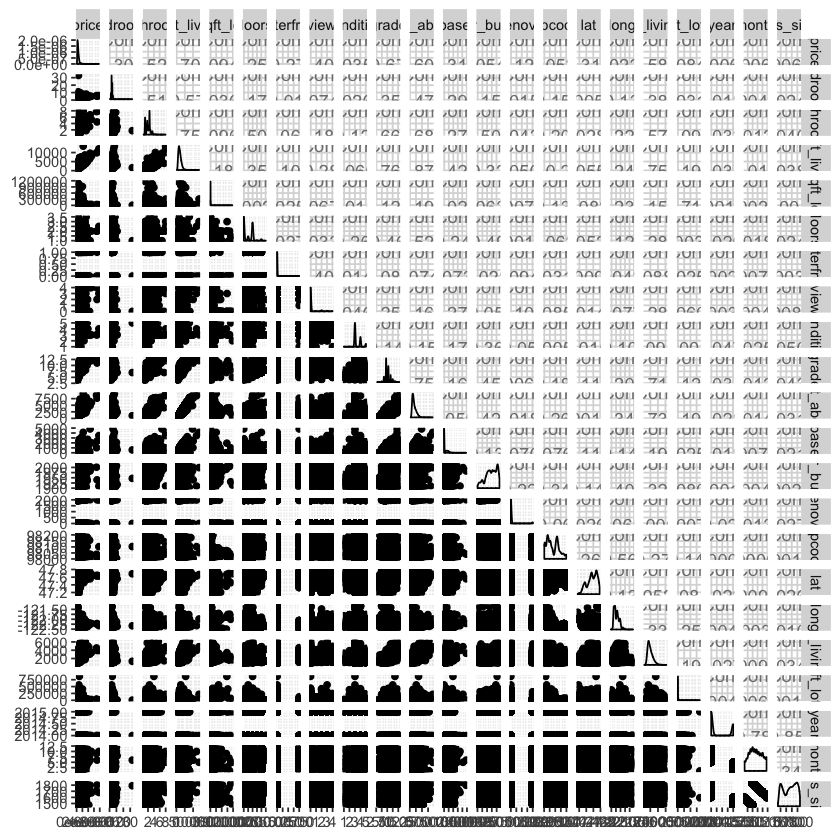

In [88]:
ggpairs(train)

In [ ]:
# # Plotting price vs all other features.
# par(mfrow=c(3,3))
# for(i in 2:19){
#   plot(df1[,i], df1$price, main=names(df1[i]), ylab=names(df1$price), xlab="", col='steelblue')
# }

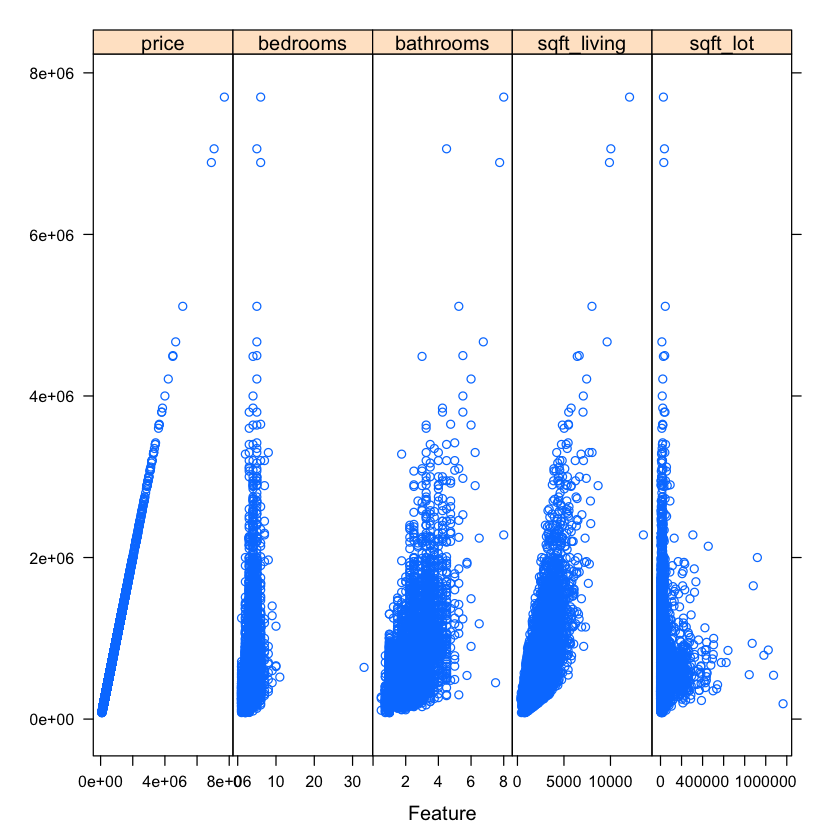

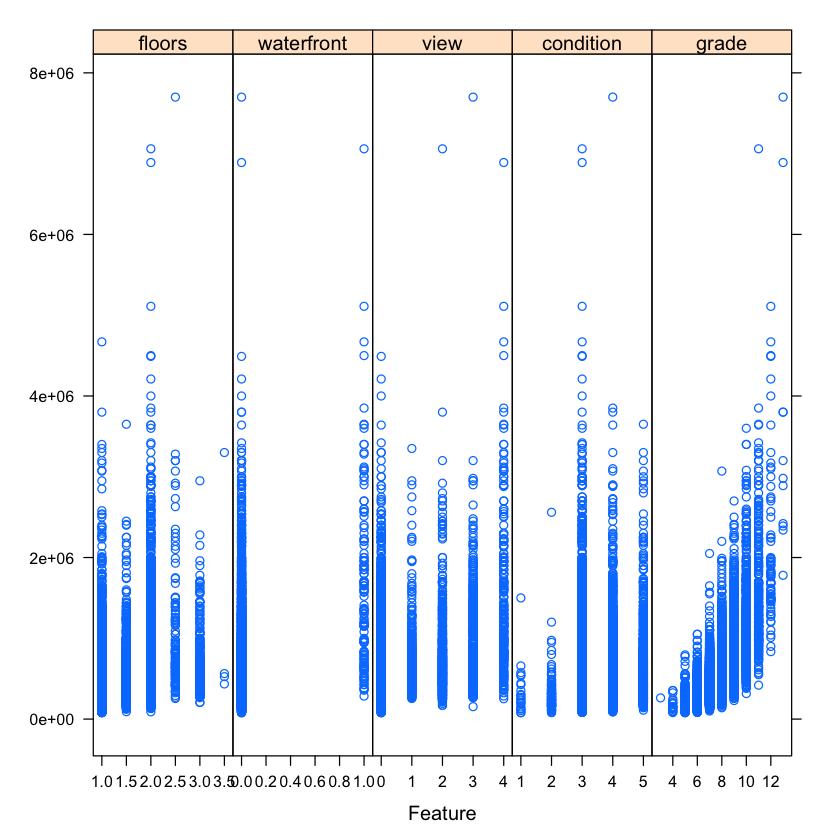

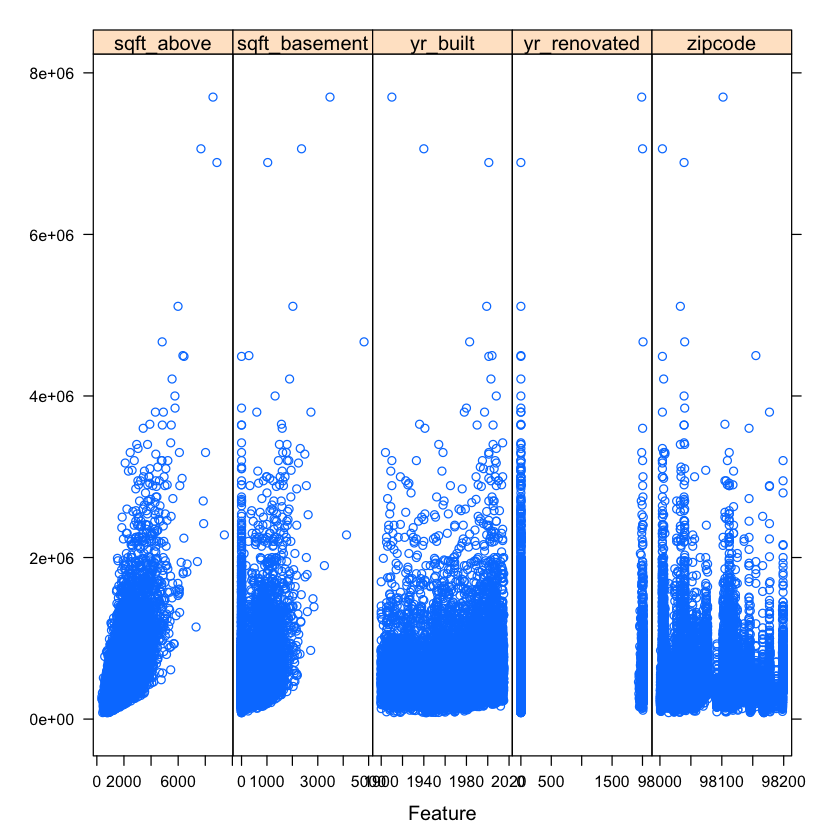

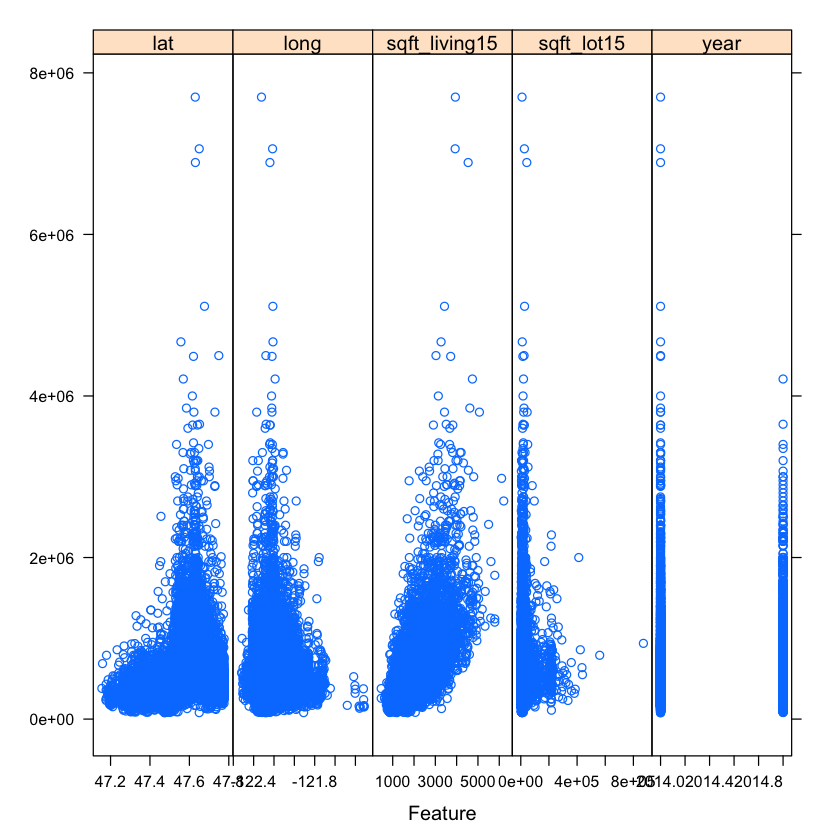

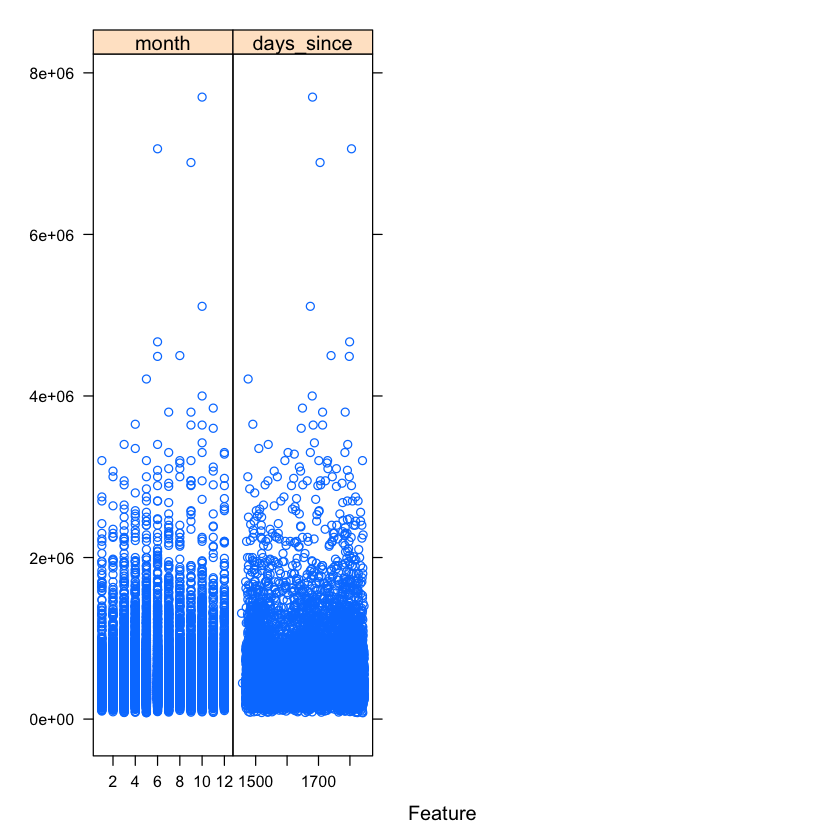

In [55]:
featurePlot(x = train, 
            y = train$price, 
            plot = "scatter", 
            layout = c(5, 1))

### Values per level

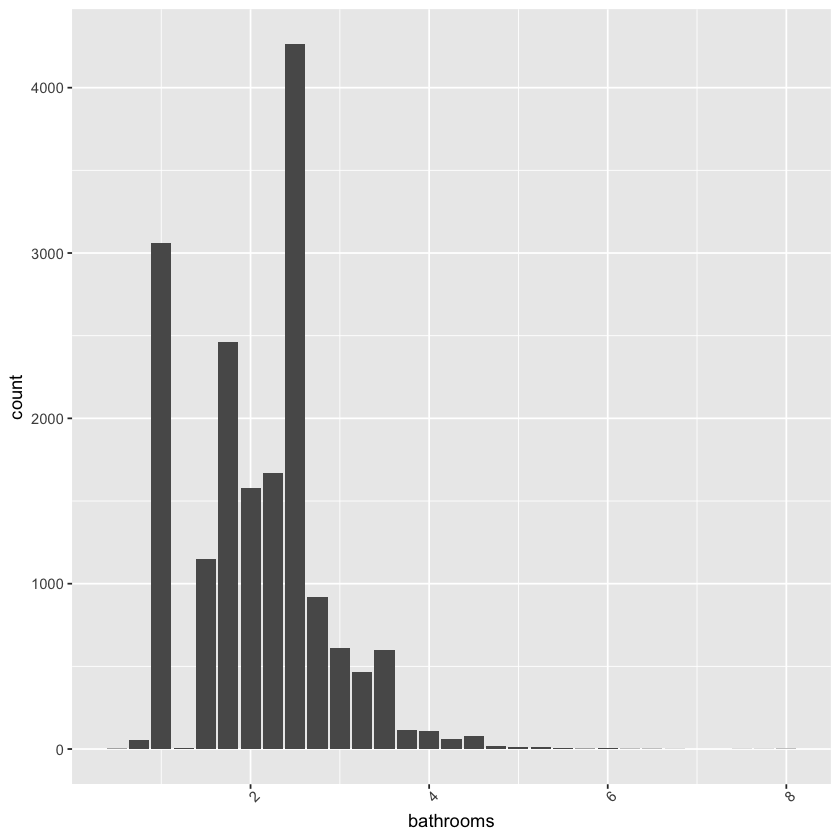

In [10]:
ggplot(train, aes(x=bathrooms))+geom_bar(stat='count')+
  theme(axis.text.x = element_text(angle=45))

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has. We will select columns that have a variance of less than 0.05 since they would probably perform poorly.

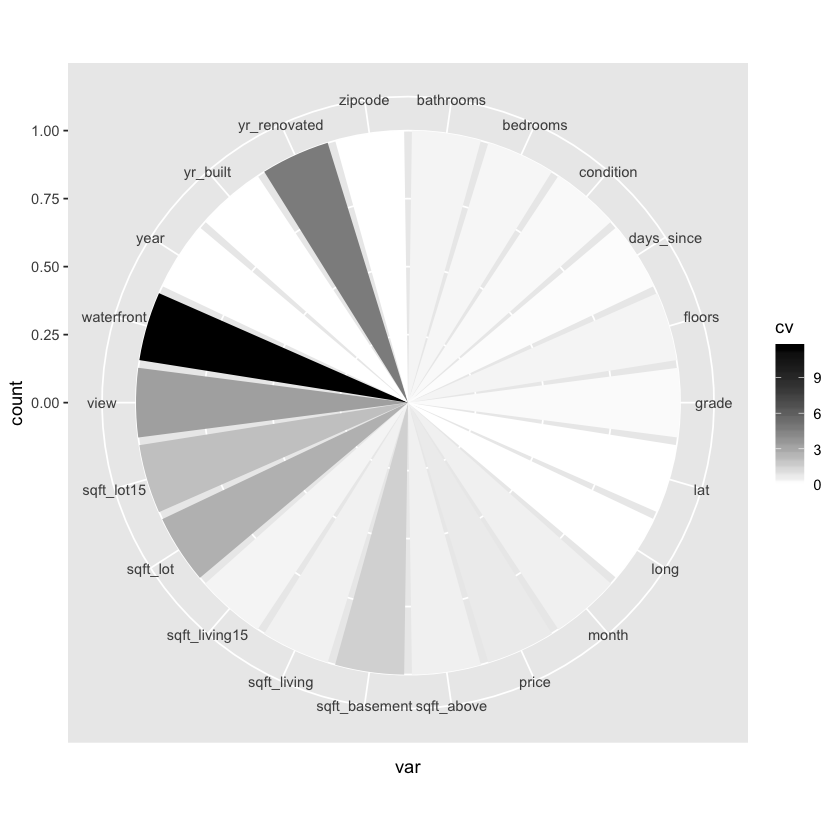

In [11]:
numeric_variables<-names(train)[sapply(train, is.numeric)]

sd_numeric_variables<-sapply(train[,numeric_variables, with=F], sd)
cv_numeric_variables<-sd_numeric_variables/colMeans(train[,numeric_variables, with=F])

ggplot(data.table(var=names(cv_numeric_variables),cv=cv_numeric_variables),
       aes(var,fill=cv))+geom_bar()+coord_polar()+scale_fill_gradient(low='white', high = 'black')

### Boxplot of Numerical Variables

We review the distribution of scaled numerical data through a boxplot for each variable.

yr_built       zipcode           lat          long          year 
 0.0149032058  0.0005462536  0.0029200229 -0.0011541909  0.0002320742 
   days_since 
 0.0680095485

No id variables; using all as measure variables


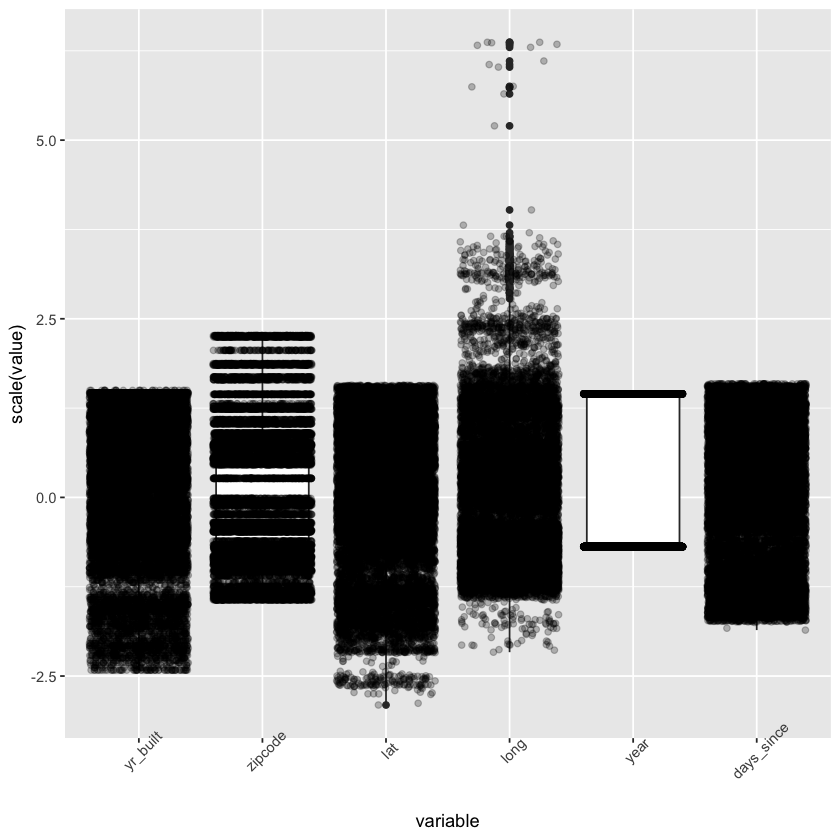

In [12]:
df<-train[, numeric_variables[cv_numeric_variables<0.1], with=F]
sapply(df, function(x) sd(x)/mean(x))
df<-data.frame(scale(df))
df<-melt(df)
       
ggplot(df, aes(x=variable, y=scale(value)))+geom_boxplot()+geom_jitter(alpha=.25)+
  theme(axis.text.x = element_text(angle=45))

# Map

In [ ]:
# KCHouseData$PriceBin<-cut(KCHouseData$price, c(0,250e3,500e3,750e3,1e6,2e6,999e6))

# center_lon = median(KCHouseData$long,na.rm = TRUE)
# center_lat = median(KCHouseData$lat,na.rm = TRUE)

# factpal <- colorFactor(c("black","blue","yellow","orange","#0B5345","red"), 
#                        KCHouseData$PriceBin)



# leaflet(KCHouseData) %>% addProviderTiles("Esri.NatGeoWorldMap") %>%
#   addCircles(lng = ~long, lat = ~lat, 
#              color = ~factpal(PriceBin))  %>%
#   # controls
#   setView(lng=center_lon, lat=center_lat,zoom = 12) %>%
  
#   addLegend("bottomright", pal = factpal, values = ~PriceBin,
#             title = "House Price Distribution",
#             opacity = 1)

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns and plot them, using a threshold of X%.

In [26]:
cor<-as.data.frame(as.table(cor(train)))
subset(cor, abs(Freq) > 0.85 & abs(Freq) < 1)

,Var1,Var2,Freq
77,sqft_above,sqft_living,0.8779126
224,sqft_living,sqft_above,0.8779126
440,days_since,year,-0.8537804
482,year,days_since,-0.8537804


### Linear Dependencies

Caret uses the QR decomposition to enumerate sets of linear combinations and therefore, remove them

In [65]:
lc<-findLinearCombos(train)
lc

$linearCombos
$linearCombos[[1]]
[1] 12  4 11


$remove
[1] 12

In [77]:
train[, 12]

sqft_basement
0
0
0
0
870
640
0
310
0
1040


The Yeo–Johnson transformation allows also for zero and negative values of y. We add a filter to check for zero- or near zero-variance predictors shicen this may cause certain models to crash or the fit to be unstable.

In [79]:
preProcess(train, method = c("center", "scale", "YeoJohnson", "nzv"))
# pp_hpc<-preProcess(train, method = c("center", "scale", "YeoJohnson"))

Created from 17277 samples and 22 variables

Pre-processing:
  - centered (22)
  - ignored (0)
  - scaled (22)
  - Yeo-Johnson transformation (15)

Lambda estimates for Yeo-Johnson transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.6843 -0.4106 -0.2146 -0.2074  0.1499  2.5153 


In [ ]:
transformed <- predict(pp_hpc, newdata = schedulingData[, -8])
head(transformed)

In [96]:
clusters <- kmeans(train[,16:17], 4)
data14$Borough <- as.factor(clusters$cluster)
str(clusters)

List of 9
 $ cluster     : int [1:17277] 3 4 1 4 4 4 1 3 3 4 ...
 $ centers     : num [1:4, 1:2] 47.6 47.5 47.4 47.7 -122 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "1" "2" "3" "4"
  .. ..$ : chr [1:2] "lat" "long"
 $ totss       : num 677
 $ withinss    : num [1:4] 68.8 29.3 66.6 36
 $ tot.withinss: num 201
 $ betweenss   : num 476
 $ size        : int [1:4] 3813 3949 4038 5477
 $ iter        : int 4
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,⋯,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,days_since
3,1.50,1250,7500,1.0,0,0,3,7,1250,⋯,1967,0,98030,47.3719,-122.215,1260,7563,2014,5,1834
3,2.50,2220,2550,3.0,0,2,3,10,2220,⋯,1990,0,98117,47.6963,-122.393,2200,5610,2014,8,1728
4,3.50,3980,209523,2.0,0,2,3,9,3980,⋯,2006,0,98024,47.5574,-121.890,2220,65775,2014,7,1768
4,1.50,1890,7540,1.0,0,0,4,7,1890,⋯,1967,0,98155,47.7534,-122.318,1890,8515,2015,1,1572
4,1.75,1814,5000,1.0,0,0,4,7,944,⋯,1951,0,98115,47.6840,-122.281,1290,5000,2014,5,1824
4,3.50,3120,5086,2.0,0,0,3,9,2480,⋯,2008,0,98115,47.6762,-122.288,1880,5092,2014,5,1827
4,3.25,4160,47480,2.0,0,0,3,10,4160,⋯,1995,0,98072,47.7266,-122.115,3400,40428,2014,12,1617
3,2.25,1440,10500,1.0,0,0,3,8,1130,⋯,1983,0,98023,47.3180,-122.391,1510,8125,2014,10,1678
4,2.50,2250,6840,2.0,0,0,3,9,2250,⋯,1987,0,98058,47.4398,-122.151,2480,7386,2014,11,1637
3,1.50,2540,9520,1.0,0,0,3,8,1500,⋯,1959,0,98115,47.6834,-122.306,1870,6800,2014,7,1765


In [99]:
#RFE
ctrl <- rfeControl(functions = lmFuncs,
                   method = "repeatedcv",
                   number = 5,
                   repeats = 5,
                   verbose = FALSE)

lmProfile <- rfe(train[,-"price"], train$price,
                 rfeControl = ctrl)

lmProfile

Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in p


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE RMSESD RsquaredSD MAESD Selected
         4 328516   0.1917 202881  22618    0.07860 10693         
         8 231069   0.6029 145020  15567    0.01540  3096         
        16 199267   0.7051 125586  12407    0.01359  1938         
        21 198837   0.7065 125385  12344    0.01307  1866        *

The top 5 variables (out of 21):
   lat, waterfront, long, year, grade


In [100]:
predictors(lmProfile)

[1] "lat"           "waterfront"    "long"          "year"         
 [5] "grade"         "view"          "bathrooms"     "bedrooms"     
 [9] "condition"     "month"         "floors"        "yr_built"     
[13] "zipcode"       "days_since"    "sqft_living"   "sqft_above"   
[17] "yr_renovated"  "sqft_living15" "sqft_lot15"    "sqft_lot"     
[21] "sqft_basement"

### Underrepresented Features

Now we determine underrepresented features, meaning those that in more than X% of the records are composed of a single value.

### Principal Component Analysis (PCA)

We plot PCA component variance to define the number of components we wish to consider if at all.

## Feature Engineering / Modeling

A number of different combinations of feature engineering steps and transformations will be performed and finally evaluated with different models, each one is cross validated to accurately review the performance of the model.

# PCA

In [ ]:
# PCAData = KCHouseData %>%
#   select(lat,long)

# pca = prcomp(PCAData, scale. = T)

# KCHouseData_pca <- predict(pca, newdata = PCAData)

# KCHouseData_pca = as.data.frame(KCHouseData_pca)

# KCHouseData2 = cbind(KCHouseData2,KCHouseData_pca)

In [29]:
lm <- train(price~ .,
                  data = train, 
                  method = "lm",
                  trControl=trainControl(
                    method = "cv",
                    number=5,
                    savePredictions = TRUE)
)

lm$results

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
TRUE,198734.6,0.7064716,125282.5,11259.33,0.009549373,1545.155


In [92]:
lmimp<-varImp(lm)

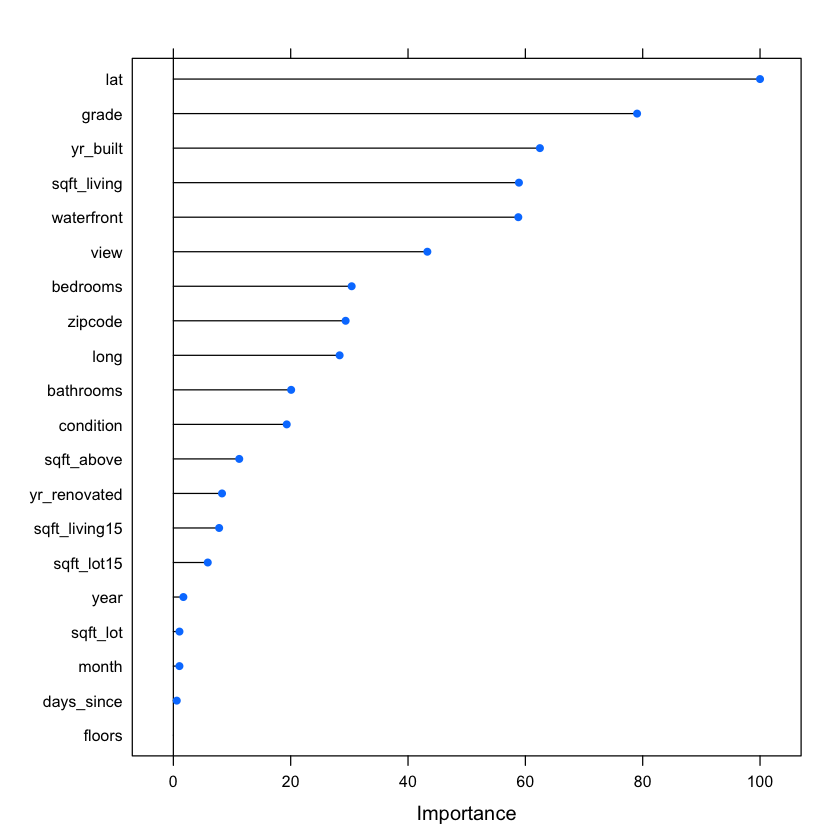

In [93]:
plot(lmimp, top = 20)

In [18]:
rf <- train(price~ .,
                  data = train, 
                  method = "ranger",
                  trControl=trainControl(
                    method = "cv",
                    number=5,
                    savePredictions = TRUE)
)

rf$results

Growing trees.. Progress: 91%. Estimated remaining time: 3 seconds.


mtry,min.node.size,splitrule,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
2,5,variance,146942.5,0.8558392,79380.93,8652.712,0.011572018,1866.249
2,5,extratrees,166113.7,0.8254520,92459.70,9136.686,0.008657553,1237.430
11,5,variance,128127.5,0.8802680,68765.53,6312.618,0.011776403,1792.859
11,5,extratrees,137370.8,0.8636818,72942.56,6997.158,0.012162152,1217.389
21,5,variance,127323.5,0.8804547,68991.66,5008.086,0.009306674,2056.141
21,5,extratrees,132486.6,0.8717975,70347.24,6895.931,0.011782024,1561.739


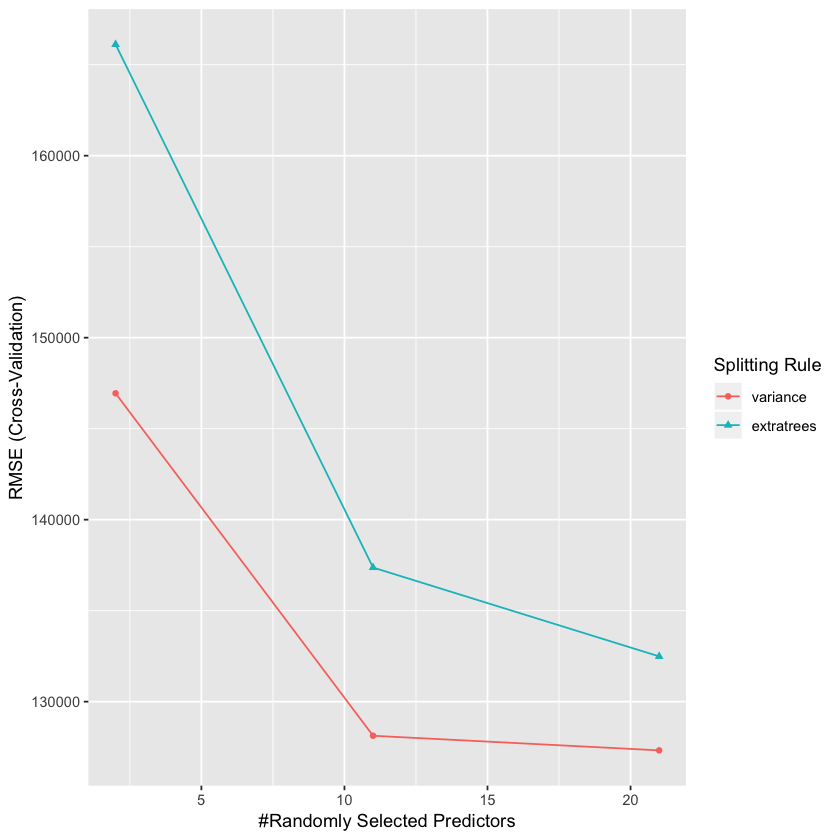

In [19]:
ggplot(rf)

In [ ]:
varImp(rf)

# Variable importance

In [ ]:
# importance = varImp(KCHouseDataModel)


# PlotImportance = function(importance)
# {
#   varImportance <- data.frame(Variables = row.names(importance[[1]]), 
#                               Importance = round(importance[[1]]$Overall,2))
  
#   # Create a rank variable based on importance
#   rankImportance <- varImportance %>%
#     mutate(Rank = paste0('#',dense_rank(desc(Importance))))
  
#   rankImportancefull = rankImportance
  
#   ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
#                              y = Importance)) +
#     geom_bar(stat='identity',colour="white", fill = fillColor) +
#     geom_text(aes(x = Variables, y = 1, label = Rank),
#               hjust=0, vjust=.5, size = 4, colour = 'black',
#               fontface = 'bold') +
#     labs(x = 'Variables', title = 'Relative Variable Importance') +
#     coord_flip() + 
#     theme_bw()
  
  
# }

# PlotImportance(importance)

In [ ]:
plsProbs <- predict(plsFit, newdata = test)
head(plsProbs)

In [31]:
xgb <- train(price~ .,
    data = train, 
    method = "xgbTree",
    trControl=trainControl(
        method = "cv",
        number=5,
        savePredictions = TRUE)
)

xgb$results

# ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
#   geom_point(alpha=0.65)+geom_line(alpha=0.65)+
#   ylim(0,50000)+xlab('')+ylab('$')+
#   ggtitle('Random Forest - Test Prediction on Automobile Price')+
#   scale_colour_manual(values = c('black','red','blue'))

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.3,1,0,0.6,1,0.50,50,188823.6,0.7354386,108186.14,9156.447,0.014295431,3333.6211
4,0.3,1,0,0.6,1,0.75,50,182396.8,0.7539144,105945.47,7755.297,0.009497264,707.4010
7,0.3,1,0,0.6,1,1.00,50,181207.6,0.7580394,104772.75,9772.821,0.012539924,2229.6676
10,0.3,1,0,0.8,1,0.50,50,185393.7,0.7459635,106853.06,7006.591,0.008091041,2401.8336
13,0.3,1,0,0.8,1,0.75,50,182373.9,0.7539955,105426.23,5626.171,0.011732159,1880.2123
16,0.3,1,0,0.8,1,1.00,50,181806.8,0.7568800,104611.39,10335.754,0.011382794,2423.4635
55,0.4,1,0,0.6,1,0.50,50,186222.6,0.7427197,108301.49,7754.712,0.008159047,2080.6095
58,0.4,1,0,0.6,1,0.75,50,180919.8,0.7572365,105753.58,8283.725,0.010938250,2831.1712
61,0.4,1,0,0.6,1,1.00,50,180290.3,0.7587539,105518.90,9013.155,0.013354722,1876.4507
64,0.4,1,0,0.8,1,0.50,50,184699.2,0.7465122,107063.47,9677.565,0.010791701,2775.7643


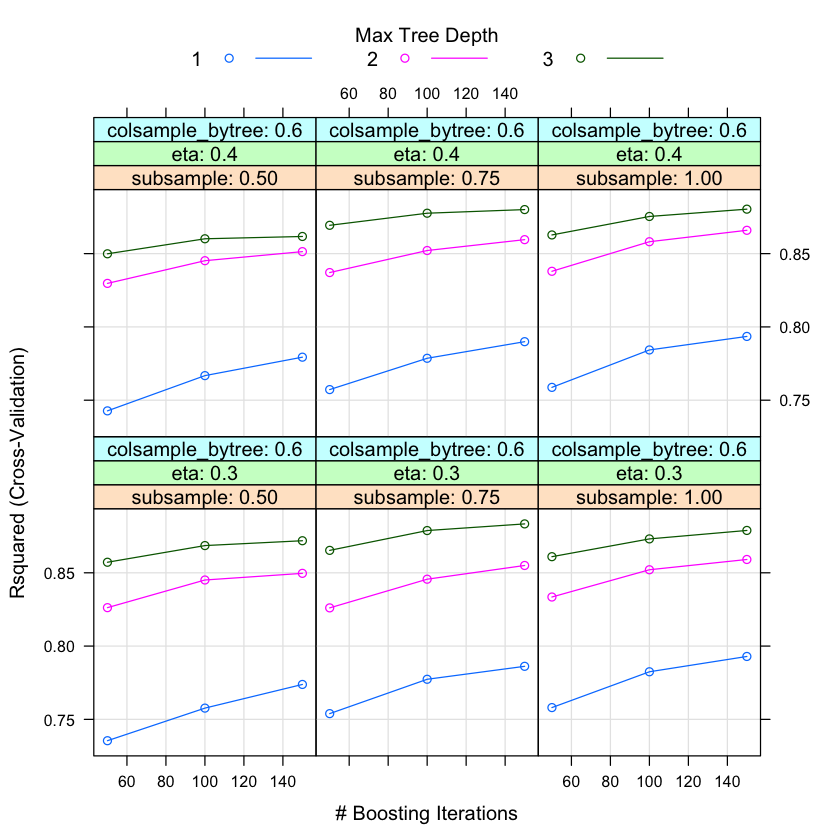

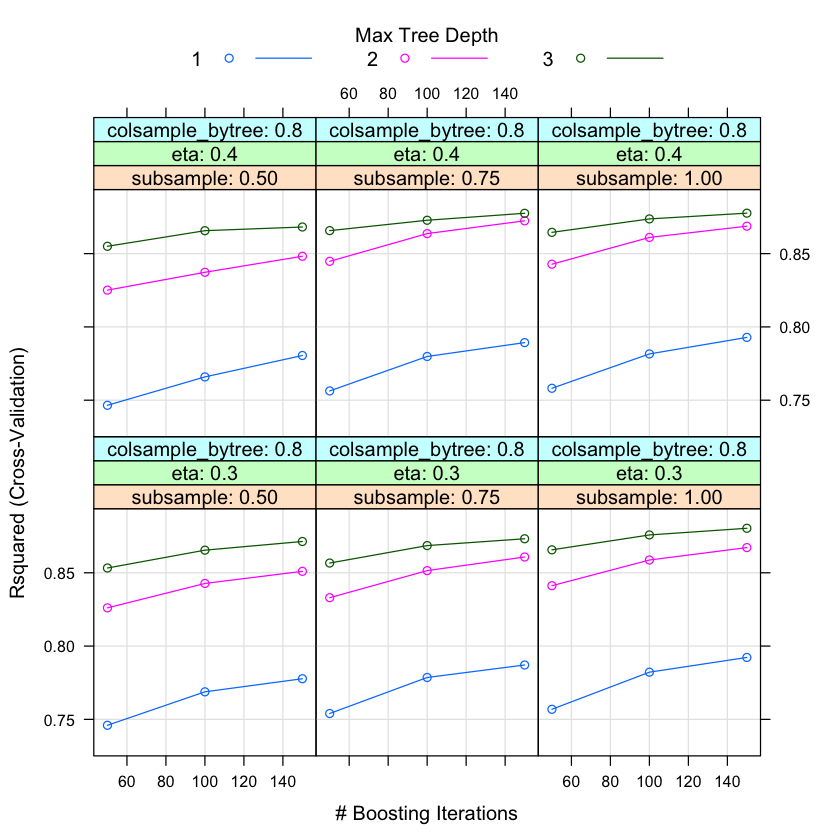

In [39]:
plot(xgb, metric = "Rsquared")

In [42]:
varImp(xgb)

xgbTree variable importance

  only 20 most important variables shown (out of 21)

                Overall
grade         1.000e+02
sqft_living   4.548e+01
lat           4.377e+01
sqft_living15 2.967e+01
long          1.782e+01
yr_built      1.129e+01
view          1.008e+01
waterfront    9.046e+00
sqft_above    8.797e+00
bathrooms     7.892e+00
zipcode       5.365e+00
sqft_lot      2.263e+00
condition     7.751e-01
days_since    7.627e-01
sqft_basement 7.539e-01
sqft_lot15    6.030e-01
yr_renovated  4.808e-01
year          7.284e-02
month         5.598e-02
bedrooms      1.093e-03

In [ ]:
#### 1.3 Boosting Tree


# for this algorithm we need to convert data to a matrix first

xgb_0<-xgboost(booster='gbtree',
               data=as.matrix(whole_data$train[, !'price', with=F]),
               label=whole_data$train$price,
               nrounds = 50,
               objective='reg:linear')
print(xgb_0)

test_xgb<-predict(xgb_0, newdata = as.matrix(whole_data$test[, !'price', with=F]), type='response')

df_pred<-cbind(df_pred, test_xgb)
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Boosted Tree - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red','blue','forestgreen'))


rmse_xgb<-rmse(real=whole_data$test$price, predicted = test_xgb)
mae_xgb<-mae(real=whole_data$test$price, predicted = test_xgb)
mape_xgb<-mape(real=whole_data$test$price, predicted = test_xgb)
mape_xgb


#### 2.3 Boosting Regression
library(xgboost)

xgb_reg_0<-xgboost(booster='gblinear',
                   data=as.matrix(whole_data$train[, !'price', with=F]),
                   label=whole_data$train$price,
                   nrounds = 100,
                   objective='reg:linear')
print(xgb_reg_0)

test_xgb_reg<-predict(xgb_reg_0, newdata = as.matrix(whole_data$test[, !'price', with=F]), type='response')

df_pred<-cbind(df_pred, test_xgb_reg)
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Boosted Regression - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red','blue','forestgreen','orange','gray','palegreen'))


rmse_xgb_reg<-rmse(real=whole_data$test$price, predicted = test_xgb_reg)
mae_xgb_reg<-mae(real=whole_data$test$price, predicted = test_xgb_reg)
mape_xgb_reg<-mape(real=whole_data$test$price, predicted = test_xgb_reg)
mape_xgb_reg

In [30]:
# Random Forest
library(ranger)

ini<-now()
rf_0<-ranger(formula=as.formula(price ~ .), data=train,num.trees = 500)
print(now()-ini)
test_rf<-predict(rf_0, test)
df_pred<-cbind(test, predictions(test_rf))
head(df_pred)

Time difference of 8.347254 secs


ERROR: Error in `[.data.frame`(x, i, j, drop): undefined columns selected


In [ ]:
# df1$zipcode <- as.factor(df1$zipcode)
# df1$grade <- as.factor(df1$grade)
# df1$waterfront <- as.factor(df1$waterfront)
# df1$floors <- as.factor(df1$floors)
# df1$bedrooms <- as.factor(df1$bedrooms)

# #One Hot Encode
# data_ready<-caret::dummyVars(formula= ~., data = data_proc, fullRank=T,sep = "_")
# data_ready<-data.table(predict(data_ready, newdata = data_proc))

# names(data_ready)<-gsub('-','_',names(data_ready))

In [ ]:
#### 1.1 Base R Partitioning Tree 
library(rpart)
library(partykit)
library(rpart.plot)
tree_0<-rpart(formula = formula, data = whole_data$train, method = 'anova', model=TRUE)

print(as.party(tree_0))

rpart.plot(tree_0, digits = 4,type = 2,box.palette = 'Gn')

test_tree<-predict(tree_0, newdata = whole_data$test,type = 'vector')

df_pred<-whole_data$test[, .(id=1:.N,price, test_tree)]
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Regression Tree - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red'))

#### 1.2 Other Random Forest
library(randomForest)

rf_0<-randomForest(formula=formula, data=whole_data$train)
print(rf_0)

test_rf<-predict(rf_0, newdata = whole_data$test, type='response')

df_pred<-cbind(df_pred, test_rf)
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Random Forest - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red','blue'))


rmse_rf<-rmse(real=whole_data$test$price, predicted = test_rf)
mae_rf<-mae(real=whole_data$test$price, predicted = test_rf)
mape_rf<-mape(real=whole_data$test$price, predicted = test_rf)
mape_rf


#### 2.1 Regression with StepWise feature selection 
library(MASS)

lm_0<-stepAIC(lm(formula = formula, 
                 data=whole_data$train),
              trace=F)

summary(lm_0)

summary(stepAIC(lm(formula = formula, 
                   data=data.frame(scale(whole_data$train))),
                trace=F))


test_lm<-predict(lm_0, newdata = whole_data$test)

df_pred<-cbind(df_pred, test_lm)
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Linear Regression - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red','blue','forestgreen','orange'))


rmse_lm<-rmse(real=whole_data$test$price, predicted = test_lm)
mae_lm<-mae(real=whole_data$test$price, predicted = test_lm)
mape_lm<-mape(real=whole_data$test$price, predicted = test_lm)
mape_lm

#### 2.2 Regression with regularization
library(glmnet)

glmnet_cv<-cv.glmnet(x = data.matrix(whole_data$train[, !'price']),
                     nfolds = 5,
                     y = whole_data$train[['price']],
                     alpha=1,
                     family = 'gaussian',
                     standardize = T)
plot.cv.glmnet(glmnet_cv)

glmnet_cv$lambda.min

glmnet_0<-glmnet(x = data.matrix(whole_data$train[, !'price']), 
                 y = whole_data$train[['price']],
                 family = 'gaussian',
                 alpha=1, lambda = glmnet_cv$lambda.min)

glmnet_0

print(glmnet_0)
glmnet_0$beta

test_glmnet<-predict(glmnet_0, newx = as.matrix(whole_data$test[, !'price']))
test_glmnet

df_pred<-cbind(df_pred, test_glmnet=test_glmnet[,1])
str(df_pred)

ggplot(melt(df_pred, id.vars = 'id'), aes(x=id,y=value, colour=variable))+
  geom_point(alpha=0.65)+geom_line(alpha=0.65)+
  ylim(0,50000)+xlab('')+ylab('$')+
  ggtitle('Lasso Regression - Test Prediction on Automobile Price')+
  scale_colour_manual(values = c('black','red','blue','forestgreen','orange','gray'))


rmse_glmnet<-rmse(real=whole_data$test$price, predicted = test_glmnet)
mae_glmnet<-mae(real=whole_data$test$price, predicted = test_glmnet)
mape_glmnet<-mape(real=whole_data$test$price, predicted = test_glmnet)
mape_glmnet


#### rf ####

# 1. Define our grid of hyperparameters to tune
tuneGrid=data.table(expand.grid(mtry=c(5,15),
                                splitrule='variance',
                                min.node.size=c(2,5,10)))


dim(tuneGrid)
tuneGrid


# 2. Define the validation squema
ctrl <- trainControl(
  method = "cv",
  number = 10,
  savePredictions=TRUE
)

# 3. Train the model
ini<-now()
set.seed(123)
rangerFit <- train(
  formula,
  data = whole_data$train,
  method = "ranger", num.trees=1000,
  preProc = NULL, 
  tuneGrid = tuneGrid,
  trControl = ctrl,
  metric = "MAE"
)
print(now()-ini)


rangerFit


# inspecting the most relevant features: 
rangerFit$results
rangerFit$bestTune
rangerFit$finalModel

# we can access the K-fold validation predictions
str(rangerFit$pred)
pred_cv<-data.table(rangerFit$pred)
pred_cv[Resample=='Fold1'&mtry==5&min.node.size==5]

# and visualize a CV summary using the established metric
plot(rangerFit)

# we save the train object
saveRDS(rangerFit,'/Users/ssobrinou/IE/Advanced/2019_Advanced/Regression/rangerFit_auto.RData')


# 4. Fit the model to all train data
library(ranger)
ini<-now()
finalmodel<-ranger(formula, data=whole_data$train,num.trees=1000,
                   mtry=rangerFit$bestTune$mtry,
                   min.node.size=rangerFit$bestTune$min.node.size)

print(now()-ini)


# 5. Predict on train (fit) and test data
pred_train<-predict(finalmodel, whole_data$train)$predictions
mape(real = whole_data$train$price,
     predicted = pred_train)
mae(real = whole_data$train$price,
    predicted = pred_train)

pred_test<-predict(finalmodel, whole_data$test)$predictions
mape(real = whole_data$test$price,
     predicted = pred_test)
mae(real = whole_data$test$price,
    predicted = pred_test)

mae(real = whole_data$test$price,
    predicted = pred_test)

df_pred<-data.table(id=1:length(pred_test),
                    real=whole_data$test$price,
                    pred_test)
df<-melt(df_pred,id.vars = 'id'); df
ggplot(df, aes(x=id, y=value, colour=variable))+geom_line()

# run in parallel

In [ ]:
# library(doParallel)
# cl <- makePSOCKcluster(5)
# registerDoParallel(cl)

# ## All subsequent models are then run in parallel
# model <- train(y ~ ., data = training, method = "rf")

# ## When you are done:
# stopCluster(cl)

## Scores

Here you can see all of the scores for the different models throughout the entire cross validation process.

### Performance by Model

## Hyperparameter Tuning

Once we have a list of models, we perform a cross validated, randomized grid search on the best performing one to define the final model.

In [ ]:
# gbmGrid <-  expand.grid(interaction.depth = c(1, 5, 9), 
#                         n.trees = (1:30)*50, 
#                         shrinkage = 0.1,
#                         n.minobsinnode = 20)
                        
# nrow(gbmGrid)

# set.seed(825)
# gbmFit2 <- train(Class ~ ., data = training, 
#                  method = "gbm", 
#                  trControl = fitControl, 
#                  verbose = FALSE, 
#                  ## Now specify the exact models 
#                  ## to evaluate:
#                  tuneGrid = gbmGrid)
# gbmFit2

In [82]:
resamps <- resamples(list(LM = lm,
                          RF = rf,
                          XGB = xgb))
resamps


Call:
resamples.default(x = list(LM = lm, RF = rf, XGB = xgb))

Models: LM, RF, XGB 
Number of resamples: 5 
Performance metrics: MAE, RMSE, Rsquared 
Time estimates for: everything, final model fit 

In [83]:
summary(resamps)


Call:
summary.resamples(object = resamps)

Models: LM, RF, XGB 
Number of resamples: 5 

MAE 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM  122846.07 124765.43 125777.19 125282.50 126313.30 126710.50    0
RF   65868.72  67988.86  69804.05  68991.66  70607.25  70689.41    0
XGB  70968.53  71072.00  72384.58  72356.42  72388.60  74968.42    0

RMSE 
        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
LM  181025.4 195193.4 201639.1 198734.6 206456.6 209358.5    0
RF  119489.8 126797.4 127063.1 127323.5 130780.4 132487.0    0
XGB 115469.1 120464.1 125321.8 125495.6 132977.4 133245.4    0

Rsquared 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM  0.6963464 0.6989935 0.7053990 0.7064716 0.7118868 0.7197323    0
RF  0.8698287 0.8716445 0.8832814 0.8804547 0.8865240 0.8909951    0
XGB 0.8756508 0.8785306 0.8818604 0.8833663 0.8871249 0.8936647    0


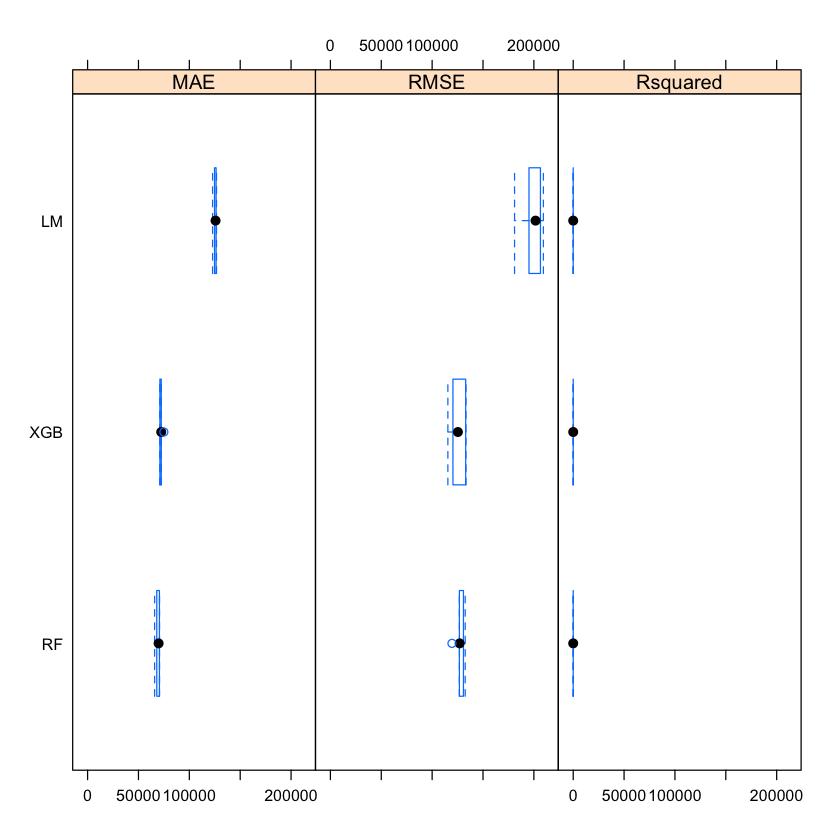

In [91]:
bwplot(resamps, layout = c(3, 1))

RANDOMIZED

In [ ]:
# Again, we will use the sonar data from the previous training page to demonstrate the method with a regularized discriminant analysis by looking at a total of 30 tuning parameter combinations:

fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 10,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary,
                           # THIS MATTERS
                           search = "random")

set.seed(825)
rda_fit <- train(Class ~ ., data = training, 
                  method = "rda",
                  metric = "ROC",
                  # THIS MATTERS
                  tuneLength = 30,
                  trControl = fitControl)
rda_fit

# Results
We evaluate the final model with the holdout, obtaining the definitive score of the model.

# Conclusions

## To Try
* Scale variables
* Remove rows that dont have bathrooms and bedrooms
* Add bathroom with toilet no shower (those with .5)
* Garden space (lot - living)
* Bigger than neighbors (sqft / 15s)
* Remove outliers (house with 33 bedrooms)
* PCA lat long / geohash / k-nearest neighbor / distance from point